In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

In [5]:
class Question():
    def __init__(self, confusion = 0.0, uncertainty = 0.0):
        self.confusion = confusion 
        self.uncertainty = uncertainty
        # confusion is a float between 0 and 1, 0 indicates no confounding answers exist, 1 indicates a single confounding answer dominates the correct answer
        # uncertainty is a float between 0 and 1, 0 indicates that a model presented with this question will always answer consistently, 1 indicates that a model presented with this question will always answer randomly
    
class Exam():
    def __init__(self, n_questions, confusions, uncertainties):
        self.n_questions = n_questions
        self.confusions = confusions
        self.uncertainties = uncertainties
        
        if isinstance(self.confusions, (int, float)):
            self.confusions = [self.confusions for i in range(n_questions)]
        if isinstance(self.uncertainties, (int, float)):
            self.uncertainties = [self.uncertainties for i in range(n_questions)]
        
        assert len(self.confusions) == n_questions, 'provided confusions list must have the same length as the number of questions'
        assert len(self.uncertainties) == n_questions, 'provided uncertainties list must have the same length as the number of questions'
        
        self.questions = [Question(d[0],d[1]) for d in zip(self.confusions, self.uncertainties)]
            
class Agent():
    def __init__(self, competence = 1):
        self.competence = competence
        # competence is a float between 0 and 1, 0 indicates the model responds completely randomly, 1 indicates the model responds in line with its belief 100% of the time

    def answer(self, question):
        adjusted_uncertainty = min(1, question.uncertainty / self.competence)
        adjusted_confusion = min(1, question.confusion / self.competence)
        return (np.random.binomial(p=1 - adjusted_confusion, n=1, ) * 2 - 1) * np.random.binomial(p=1 - adjusted_uncertainty, n=1, ) # 1 if correct, -1 if confused, 0 if stochastic
    
    def take_exam(self, exam):
        return [self.answer(q) for q in exam.questions]
            
class Ensemble():
    def __init__(self, n_agents, competencies):
        self.n_agents = n_agents
        self.competencies = competencies
        
        if isinstance(self.competencies, (int, float)):
            self.agents = [Agent(competencies) for i in range(n_agents)]
        elif type(self.competencies) == list or type(self.competencies) == np.ndarray:
            assert len(self.competencies) == n_agents, 'provided competencies list must have the same length as the number of agents'
            self.agents = [Agent(c) for c in self.competencies]
        else:
            assert False, 'competencies must be either an number, a list or a numpy array'
                    
    def take_exam(self, exam):
        return [a.take_exam(exam) for a in self.agents]
    
    def vote(self, answers, threshold):
        answers = np.array(answers)
        consensus = np.mean(np.where(answers != 0, 1, 0), axis=0) >= threshold
        responses = np.where(np.mean(answers, axis=0) > 0, 1, 0)
        responses = np.where(np.mean(answers, axis=0) < 0, -1, responses)
        return responses * consensus
    
    def vote_count(self, responses):
        return [np.sum(np.array(responses) == i) for i in [-1, 0, 1]]
        

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:17<00:00,  5.57it/s]
/tmp/ipykernel_528376/3592490829.py:27: RuntimeWarning: invalid value encountered in divide
  inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
/tmp/ipykernel_528376/3592490829.py:28: RuntimeWarning: Mean of empty slice
  inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)


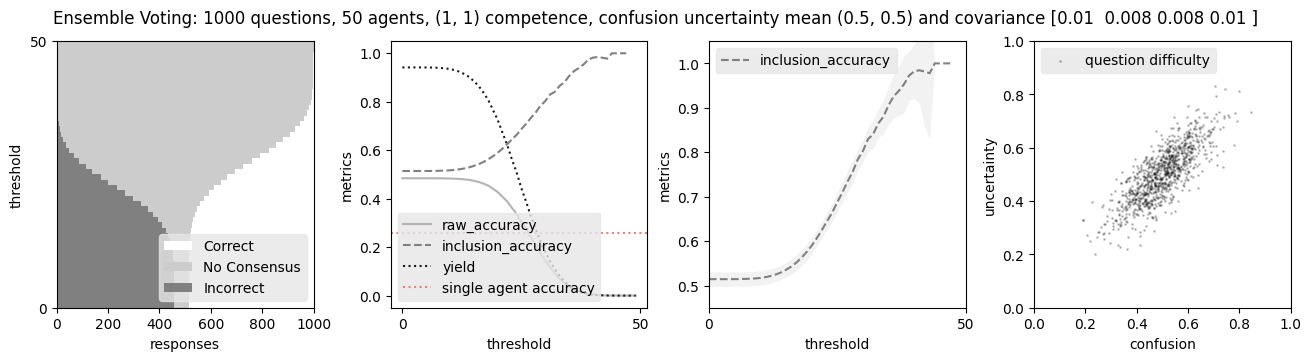

In [45]:
questions = 1000
agents = 50
thresholds = agents
competence = (1, 1)
confusion_uncertainty_mean = (0.5,0.5)
confusion_uncertainty_covariance = 0.01*np.array([[1,0.8],[0.8,1]])

running_vals = []
ensemble_responses_list = []
for i in tqdm.tqdm(range(100)):
    confusion_uncertainty = np.clip(np.random.multivariate_normal(confusion_uncertainty_mean, confusion_uncertainty_covariance, questions), 0, 1)
    exam = Exam(questions, confusions = confusion_uncertainty[:,0], uncertainties = confusion_uncertainty[:,1])
    ensemble = Ensemble(n_agents = agents, competencies = np.random.uniform(competence[0], competence[1], agents))
    ensemble_responses = ensemble.take_exam(exam)
    values = [ensemble.vote_count(ensemble.vote(ensemble_responses, thresh)) for thresh in np.linspace(0, 1, thresholds)]
    running_vals.append(values)
    ensemble_responses_list.append(ensemble_responses)

mean_values = np.mean(np.array(running_vals), axis=0)

raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)

single_model_acc = np.mean(np.where(np.array(ensemble_responses_list) == 1, 1, 0))
single_model_acc_std = np.std(np.where(np.array(ensemble_responses_list) == 1, 1, 0))

fig, ax = plt.subplots(1,4, figsize=(13,3.5), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, questions])
ax[0].set_yticks([0, thresholds])
# ax[0].set_yticklabels(['0', '1'])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].axhline(y=single_model_acc, color=[0.9,0.5,0.5], linestyle=':', label='single agent accuracy')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
# ax[1].set_xticklabels(['0', '1'])
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[2].set_ylabel('metrics')
ax[2].set_ylim([0.45, 1.05])
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
# ax[2].set_xticklabels(['0', '1'])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ax[2].fill_between(np.arange(thresholds),
#                 inclusion_accuracy_lower,
#                 inclusion_accuracy_upper,
#                 color=[0.9,0.9,0.9], alpha=1, linewidth=0)
ax[2].fill_between(np.arange(thresholds),
                inclusion_accuracy_mean - inclusion_accuracy_std,
                inclusion_accuracy_mean + inclusion_accuracy_std,
                color=[0.95,0.95,0.95], alpha=1, linewidth=0)

ax[3].scatter(confusion_uncertainty[:,0], confusion_uncertainty[:,1], s=1, c='k', alpha=0.2, label='question difficulty')
ax[3].set_xlabel('confusion')
ax[3].set_ylabel('uncertainty')
ax[3].set_xlim([0, 1])
ax[3].set_ylim([0, 1])
ax[3].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ax[3].hist(np.random.uniform(competence[0], competence[1], agents), label='competence', bins=10, color=[0.5,0.5,0.5], alpha=0.5)
# ax[3].set_xlabel('competence')
# ax[3].set_ylabel('agents')
# ax[3].set_xlim([0, 1])
# # ax[3].set_ylim([0, 1])
# ax[3].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

plt.suptitle(f'Ensemble Voting: {questions} questions, {agents} agents, {competence} competence, confusion uncertainty mean {confusion_uncertainty_mean} and covariance {confusion_uncertainty_covariance.flatten()}', fontsize=12)
plt.savefig(f'EnsembleVoting_q{questions}_a{agents}_pumean{confusion_uncertainty_mean}_pucov{confusion_uncertainty_covariance.flatten()}_c{competence[0]}-{competence[1]}.png', format='png', dpi=300)

100%|██████████| 100/100 [00:17<00:00,  5.64it/s]
/tmp/ipykernel_368828/3619569355.py:25: RuntimeWarning: invalid value encountered in divide
  inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
/tmp/ipykernel_368828/3619569355.py:26: RuntimeWarning: Mean of empty slice
  inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)
/home/trevor/miniconda3/envs/ensembles/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2053: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/trevor/miniconda3/envs/ensembles/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1650: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


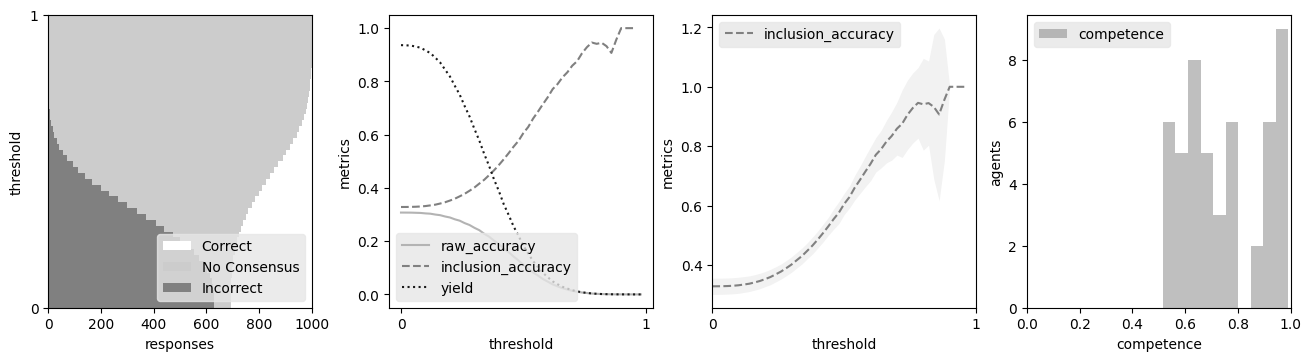

In [6]:
questions = 1000
agents = 50
thresholds = 50
competence = (0.5, 1.0)
confusion_uncertainty_mean = (0.45,0.45)
confusion_uncertainty_covariance = 0.01*np.array([[1,0.8],[0.8,1]])

running_vals = []
for i in tqdm.tqdm(range(100)):
    confusion_uncertainty = np.clip(np.random.multivariate_normal(confusion_uncertainty_mean, confusion_uncertainty_covariance, questions), 0, 1)
    exam = Exam(questions, confusions = confusion_uncertainty[:,0], uncertainties = confusion_uncertainty[:,1])
    ensemble = Ensemble(n_agents = agents, competencies = np.random.uniform(competence[0], competence[1], agents))
    ensemble_answers = ensemble.take_exam(exam)
    values = [ensemble.vote_count(ensemble.vote(ensemble_answers, thresh)) for thresh in np.linspace(0, 1, thresholds)]
    running_vals.append(values)

mean_values = np.mean(np.array(running_vals), axis=0)

raw_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_accuracy_mean = np.nanmean(raw_accuracy, axis=0)

raw_yield = (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2]) / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,1] + np.array(running_vals)[:,:,2])
raw_yield_mean = np.nanmean(raw_yield, axis=0)

inclusion_accuracy = np.array(running_vals)[:,:,2] / (np.array(running_vals)[:,:,0] + np.array(running_vals)[:,:,2])
inclusion_accuracy_mean = np.nanmean(inclusion_accuracy, axis=0)

inclusion_accuracy_std = np.nanstd(inclusion_accuracy, axis=0)
inclusion_accuracy_lower = np.nanpercentile(inclusion_accuracy, 2.5, axis=0)
inclusion_accuracy_upper = np.nanpercentile(inclusion_accuracy, 97.5, axis=0)


fig, ax = plt.subplots(1,4, figsize=(13,3.5), constrained_layout=True)

ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1] + np.array(mean_values)[:,2], fill=True, orientation='horizontal', color=[1,1,1], label='Correct')
ax[0].stairs(np.array(mean_values)[:,0] + np.array(mean_values)[:,1], fill=True, orientation='horizontal', color=[0.8,0.8,0.8], label='No Consensus')
ax[0].stairs(np.array(mean_values)[:,0], fill=True, orientation='horizontal', color=[0.5,0.5,0.5], label='Incorrect')
ax[0].set_ylim([0, thresholds])
ax[0].set_xlim([0, questions])
ax[0].set_yticks([0, thresholds])
ax[0].set_yticklabels(['0', '1'])
ax[0].set_ylabel('threshold')
ax[0].set_xlabel('responses')
ax[0].legend(loc = 'lower right', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[1].plot(raw_accuracy_mean, color=[0.7,0.7,0.7], label='raw_accuracy')
ax[1].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[1].plot(raw_yield_mean, color=[0.1,0.1,0.1], linestyle=':', label='yield')
ax[1].set_ylabel('metrics')
ax[1].set_xlabel('threshold')
ax[1].set_xticks([0, thresholds])
ax[1].set_xticklabels(['0', '1'])
ax[1].legend(loc = 'lower left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[2].plot(inclusion_accuracy_mean, color=[0.5,0.5,0.5], linestyle='--', label='inclusion_accuracy')
ax[2].set_ylabel('metrics')
# ax[2].set_ylim([0.6, 1.05])
ax[2].set_xlabel('threshold')
ax[2].set_xlim([0, thresholds])
ax[2].set_xticks([0, thresholds])
ax[2].set_xticklabels(['0', '1'])
ax[2].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# ax[2].fill_between(np.arange(thresholds),
#                 inclusion_accuracy_lower,
#                 inclusion_accuracy_upper,
#                 color=[0.9,0.9,0.9], alpha=1, linewidth=0)
ax[2].fill_between(np.arange(thresholds),
                inclusion_accuracy_mean - inclusion_accuracy_std,
                inclusion_accuracy_mean + inclusion_accuracy_std,
                color=[0.95,0.95,0.95], alpha=1, linewidth=0)

# ax[3].scatter(confusion_uncertainty[:,0], confusion_uncertainty[:,1], s=1, c='k', alpha=0.2, label='question difficulty')
# ax[3].set_xlabel('confusion')
# ax[3].set_ylabel('uncertainty')
# ax[3].set_xlim([0, 1])
# ax[3].set_ylim([0, 1])
# ax[3].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

ax[3].hist(np.random.uniform(competence[0], competence[1], agents), label='competence', bins=10, color=[0.5,0.5,0.5], alpha=0.5)
ax[3].set_xlabel('competence')
ax[3].set_ylabel('agents')
ax[3].set_xlim([0, 1])
# ax[3].set_ylim([0, 1])
ax[3].legend(loc = 'upper left', frameon = True, facecolor = [0.9, 0.9, 0.9], edgecolor = [0.9, 0.9, 0.9])

# plt.suptitle(f'Ensemble Voting: {questions} questions, {agents} agents, {competence} competence, confusion uncertainty mean {confusion_uncertainty_mean} and covariance {confusion_uncertainty_covariance.flatten()}', fontsize=12)
# plt.savefig(f'EnsembleVoting_q{questions}_a{agents}_pumean{confusion_uncertainty_mean}_pucov{confusion_uncertainty_covariance.flatten()}_c{competence[0]}-{competence[1]}.png', format='png', dpi=300)

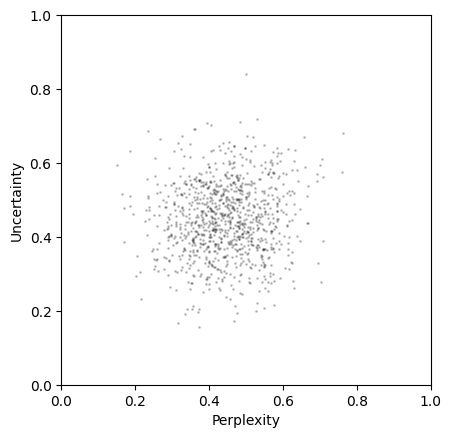

In [130]:
confusion_uncertainty = np.clip(np.random.multivariate_normal([0.45,0.45], 0.01*np.array([[1,0],[0,1]]), questions), 0, 1)

plt.scatter(confusion_uncertainty[:,0], confusion_uncertainty[:,1], s=1, c='k', alpha=0.2, label='question difficulty')
plt.xlabel('confusion')
plt.ylabel('Uncertainty')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.gca().set_aspect('equal', adjustable='box')